# Cryptocurrency Portfolio Tracker

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#get plots to show up inline
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [2]:
data = pd.read_csv("Crypto - Tracker.csv")
data.head()

,Time Stamp,Total USD,%ETH
0,7/3/17 9:19,57253.23021,80.80361253
1,7/3/17 9:30,57602.01983,80.80575251
2,7/3/17 10:24,56889.20284,80.65272462
3,7/3/17 11:30,56807.57633,80.98716297
4,7/3/17 12:30,56760.18843,81.10275725


In [3]:
data.describe()

,Time Stamp,Total USD,%ETH
count,542,542,542
unique,542,239,239
top,7/20/17 18:30,#ERROR!,#ERROR!
freq,1,276,276


### Cleaning dataframe

In [4]:
data.columns = ['time', 'totusd','percenteth']
df = data[data.totusd != '#ERROR!']
df = df[df.totusd != '#NAME?']
df.shape

(241, 3)

In [5]:
df[['time']] = df[['time']].apply(pd.to_datetime)
df[['totusd','percenteth']]=df[['totusd','percenteth']].apply(pd.to_numeric)
df = df.set_index('time')

df.head()

,totusd,percenteth
time,,
2017-07-03 09:19:00,57253.23021,80.803613
2017-07-03 09:30:00,57602.01983,80.805753
2017-07-03 10:24:00,56889.20284,80.652725
2017-07-03 11:30:00,56807.57633,80.987163
2017-07-03 12:30:00,56760.18843,81.102757


### Show Time Plots

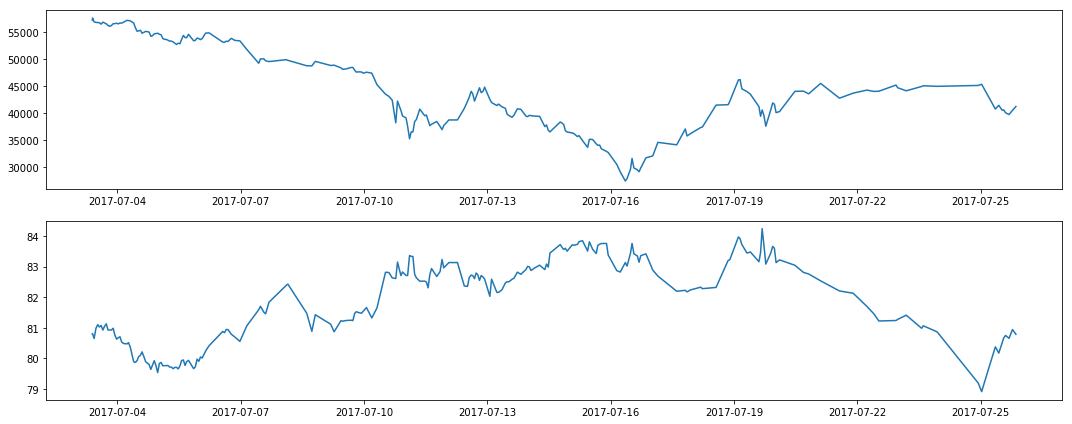

In [6]:
usdVal = df['totusd']
ethPercent = df['percenteth']

plt.subplot(211)
plt.plot(usdVal)
plt.subplot(212)
plt.plot(ethPercent)
plt.tight_layout()


### Stationarity Test: Exponentially Weighted Moving Average

In [7]:
from statsmodels.tsa.stattools import adfuller

usdVal_trans = np.cbrt(usdVal) #Takes cube root of totusd values

def testStationarity(timeSeriesData, windowInt):
    
    #determine rolling mean and standard deviation
    rolMean = timeSeriesData.rolling(window = windowInt).mean()
    rolStd = timeSeriesData.rolling(window = windowInt).std()
    
    #determine Dickey-Fuller test statistics
    dftest = adfuller(timeSeriesData, autolag = "AIC")
    dfOutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "Number of Lags", "Number of Observations"])
    for key,val in dftest[4].items():
        dfOutput["Critical Value (%s)"%key] = val
    
    #plot rolling stats
    dataPlot = plt.plot(timeSeriesData, label = "data")
    meanPlot = plt.plot(rolMean, label = "Rolling Mean")
    stdPlot = plt.plot(rolStd, label = "Standard Deviation")
    plt.xlabel("Date: YYYY-MM-DD")
    plt.legend(loc="upper left")
    plt.title("Rolling Statistics: Mean and Standard Deviation")
    plt.show(block = False)
        
    #output DF results
    print(dfOutput)

/Users/dev/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


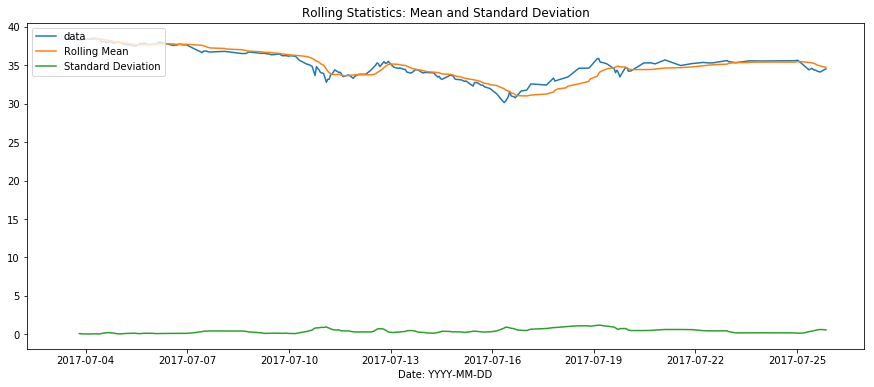

Test Statistic             -1.565505
p-value                     0.500895
Number of Lags              0.000000
Number of Observations    240.000000
Critical Value (1%)        -3.457894
Critical Value (5%)        -2.873659
Critical Value (10%)       -2.573229
dtype: float64


In [8]:
testStationarity(usdVal_trans, 12)

## Removing Trends and Seasonality Using Differencing

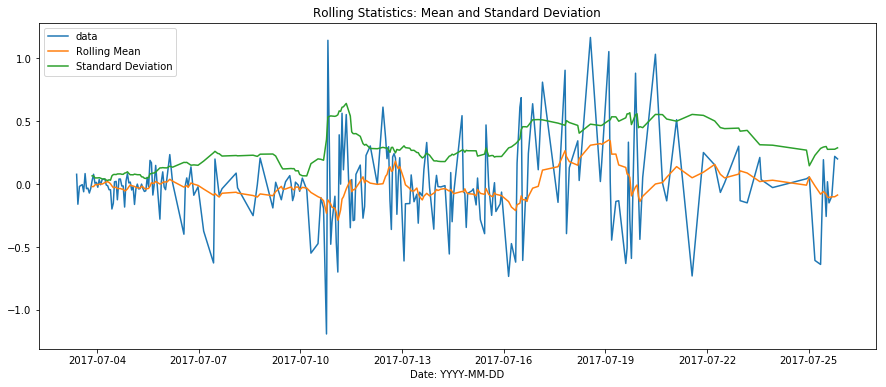

Test Statistic           -1.551322e+01
p-value                   2.334090e-28
Number of Lags            0.000000e+00
Number of Observations    2.390000e+02
Critical Value (1%)      -3.458011e+00
Critical Value (5%)      -2.873710e+00
Critical Value (10%)     -2.573256e+00
dtype: float64


In [9]:
usdVal_diff = usdVal_trans - usdVal_trans.shift() #using difference method
usdVal_diff.dropna(inplace = True)

testStationarity(usdVal_diff, 12)

## ARIMA Model

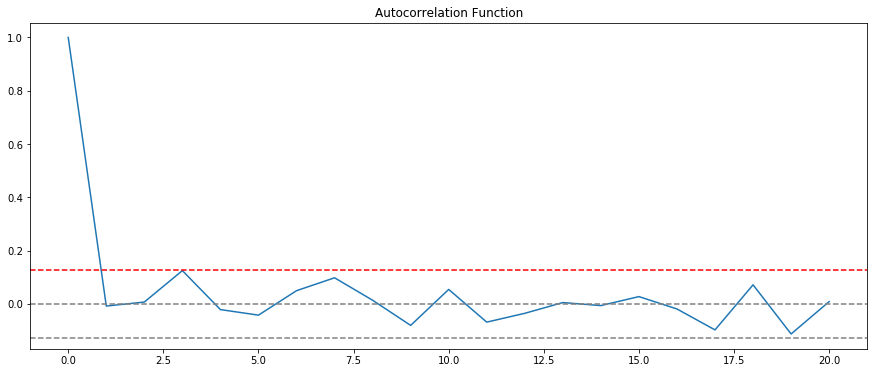

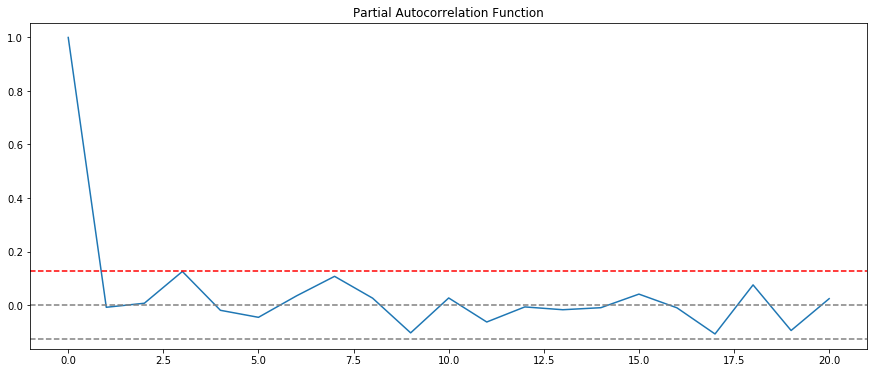

In [10]:
from statsmodels.tsa.stattools import acf, pacf

lagACF = acf(usdVal_diff, nlags = 20)
lagPACF = pacf(usdVal_diff, nlags = 20, method = 'ols')

plt.plot(lagACF)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(usdVal_diff)), linestyle = '--', color = 'gray') #confidence intervals: +- sigma/sqrt(n)
plt.axhline(y = 1.96 / np.sqrt(len(usdVal_diff)), linestyle = '--', color = 'red')
plt.title('Autocorrelation Function')
plt.show()

plt.plot(lagPACF)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(usdVal_diff)), linestyle = '--', color = 'gray') #confidence intervals: +- sigma/sqrt(n)
plt.axhline(y = 1.96 / np.sqrt(len(usdVal_diff)), linestyle = '--', color = 'red')
plt.title('Partial Autocorrelation Function')
plt.show()



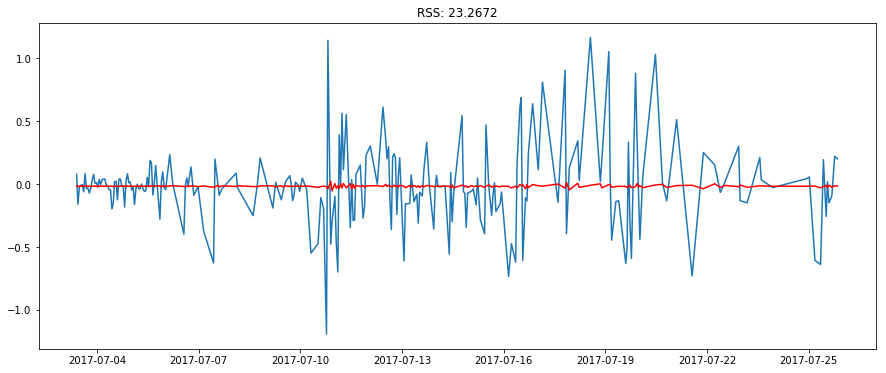

In [11]:
p=1
q=1

from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(usdVal_trans, order = (p,1,q))
results_ARIMA = model.fit()
plt.plot(usdVal_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-usdVal_diff)**2)) #residual sum of squares

In [12]:
predARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
predARIMA.head()

time
2017-07-03 09:30:00   -0.016637
2017-07-03 10:24:00   -0.014735
2017-07-03 11:30:00   -0.020906
2017-07-03 12:30:00   -0.013644
2017-07-03 13:30:00   -0.018640
dtype: float64

### Scaling: converting from difference to cube root

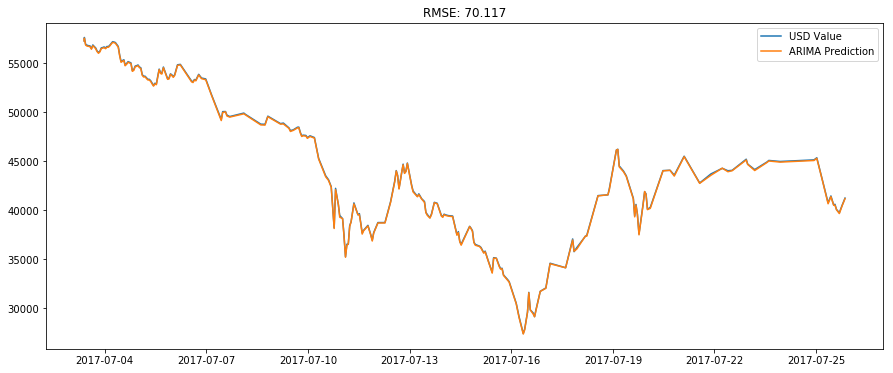

In [13]:
predARIMA_cbrt = pd.Series(usdVal_trans, index = usdVal_trans.index)
predARIMA_cbrt = predARIMA_cbrt.add(predARIMA, fill_value = 0)

predictions = (predARIMA_cbrt)**3

plt.plot(usdVal, label = "USD Value")
plt.plot(predictions, label = "ARIMA Prediction")
plt.legend(loc="best")
plt.title("RMSE: %.3f"%np.sqrt(sum((predictions - usdVal)**2)/len(usdVal)))